# Team Benchmark

**Authors:** Marissa Nicole Esteban, Gabe Krishnadasan, Diana Montoya-Herrera, Gabe Seidl, Madeleine Woo

**Date:** 10/5/2023

### Wave Height

#### Dataset: https://www.kaggle.com/code/shaltaf/the-prediction-of-significant-wave-height-hs/notebook 

## Table of Contents:
* [Data Importing and Pre-processing](#data-importing)
* [Data Analysis and Visualization](#data-vis)
* [Data Analytics](#data-analytics)

In [3]:
# import libraries needed
from seebuoy import NDBC
from IPython.display import display
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import sys
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [4]:
from seebuoy import NDBC

ndbc = NDBC()

# Information on NDBC's ~1800 buoys and gliders
wave_df = ndbc.stations()

# list all available data for all buoys
df_data = ndbc.available_data()

# Get info on NY Harbor Buoy
station_id = "44065"
ny_buoy = ndbc.get_data(station_id)
ny_buoy

,wind_direction,wind_speed,wind_gust,wave_height,dominant_period,average_period,mean_wave_direction,pressure,air_temp,water_temp,dewpoint,visibility,pressure_tendency,tide
date,,,,,,,,,,,,,,
2024-02-03 00:00:00,NaN,10.0,12.0,NaN,NaN,NaN,NaN,1012.7,NaN,5.9,NaN,NaN,2.1,NaN
2024-02-03 00:10:00,NaN,10.0,11.0,1.0,NaN,4.0,142.0,1012.7,NaN,5.9,NaN,NaN,NaN,NaN
2024-02-03 00:20:00,NaN,9.0,12.0,1.0,9.0,4.0,142.0,1012.9,NaN,5.9,NaN,NaN,NaN,NaN
2024-02-03 00:30:00,NaN,9.0,11.0,NaN,NaN,NaN,NaN,1013.1,NaN,5.9,NaN,NaN,NaN,NaN
2024-02-03 00:40:00,NaN,9.0,11.0,NaN,NaN,NaN,NaN,1013.1,NaN,5.9,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-19 20:30:00,NaN,6.0,8.0,NaN,NaN,NaN,NaN,1005.3,NaN,6.9,NaN,NaN,NaN,NaN
2024-03-19 20:40:00,NaN,7.0,8.0,NaN,NaN,NaN,NaN,1005.2,NaN,6.9,NaN,NaN,NaN,NaN
2024-03-19 20:50:00,NaN,7.0,9.0,0.8,4.0,3.4,294.0,1005.2,NaN,6.9,NaN,NaN,NaN,NaN


In [5]:
ny_buoy = ny_buoy.reset_index()
#ny_buoy["average_period_0_for_null"] = ny_buoy["average_period"].fillna(0)

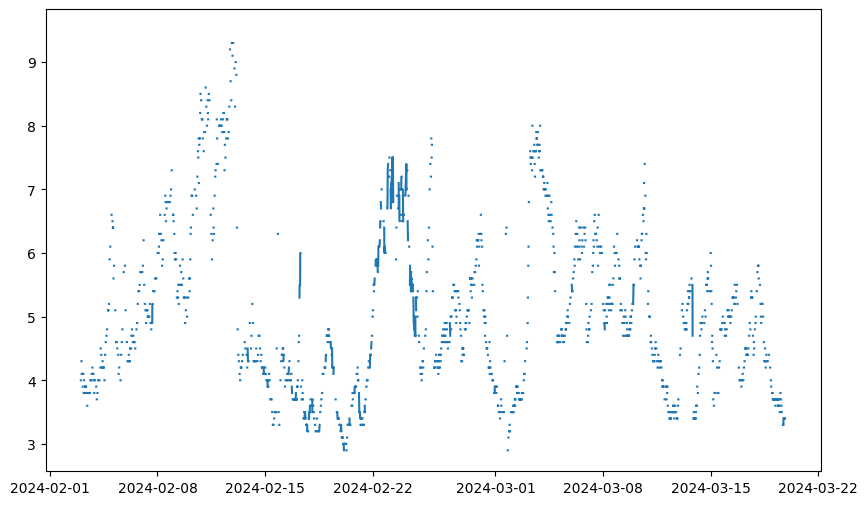

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(ny_buoy["date"], ny_buoy["average_period"]) # including NULL values

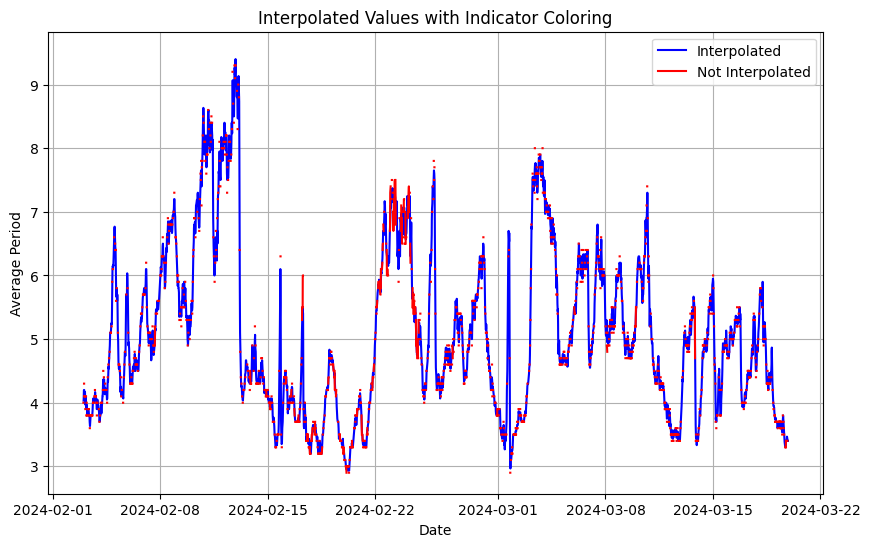

In [7]:
# lets limit the df to 2 columns: date and wave height
ny_buoy_df = ny_buoy[["date","average_period"]]

# Set 'date' column as the index
ny_buoy_df = ny_buoy_df.set_index("date")

ny_buoy_df['average_period_interpolated'] = ny_buoy_df['average_period'].interpolate(method='time') # interpolate missing values based on time
ny_buoy_df['interpolation_indicator'] = ny_buoy_df['average_period'].isna()

ny_buoy_df = ny_buoy_df.reset_index()

plt.figure(figsize=(10, 6))
#plt.plot(ny_buoy_df["average_period"]) # interpolated NULL values

plt.plot(ny_buoy_df['date'][ny_buoy_df['interpolation_indicator']], ny_buoy_df['average_period_interpolated'][ny_buoy_df['interpolation_indicator']], color='blue', label='Interpolated')
plt.plot(ny_buoy_df['date'], ny_buoy_df['average_period'], color='red', label='Not Interpolated')

plt.xlabel('Date')
plt.ylabel('Average Period')
plt.title('Interpolated Values with Indicator Coloring')
plt.legend()

plt.grid(True)
plt.show()

In [8]:
# lets use the interpolated values and see how good we are at modeling the future
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [9]:
modeling_df = ny_buoy_df[["date","average_period_interpolated"]]
modeling_df = modeling_df.rename(columns={"date": "ds", "average_period_interpolated": "y"})

# Initialize Prophet model
model = Prophet()
model.fit(modeling_df)

14:40:42 - cmdstanpy - INFO - Chain [1] start processing
14:40:45 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future = model.make_future_dataframe(periods=10)
forecast = model.predict(future)

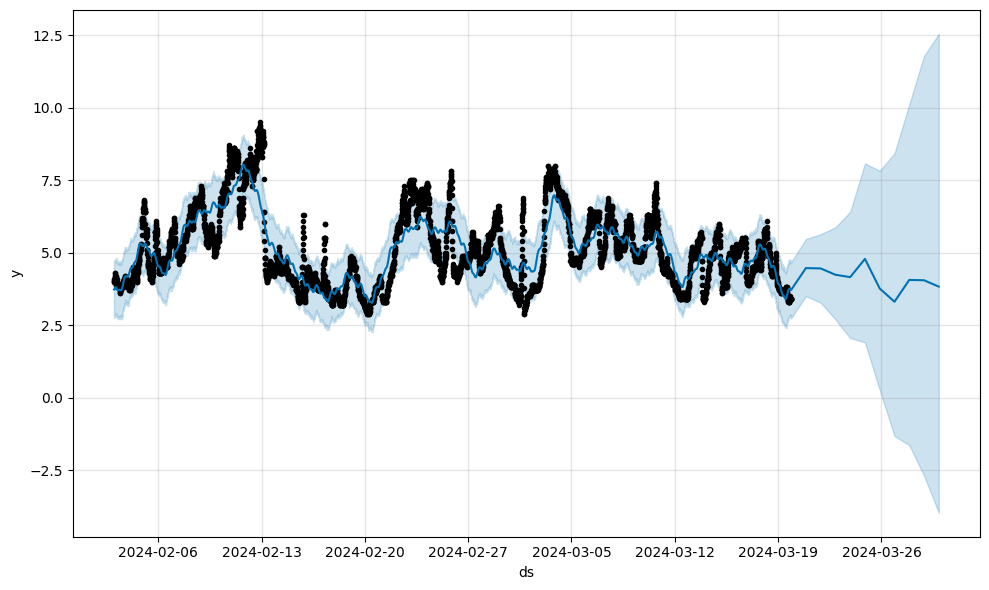

In [11]:
fig1 = model.plot(forecast)

In [18]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime, timedelta

# Assuming 'df' is your DataFrame with DateTimeIndex and 'average_period' is your target variable
# You can adjust these steps according to your actual DataFrame structure

# Train-test split
last_date = ny_buoy_df.index[-1]  # Get the last date in the index
type(last_date)
split_date = last_date - timedelta(days=15) # Calculate the date 15 days before the last date

train_data = ny_buoy_df.loc[ny_buoy_df.index < split_date]  # Training data before split_date
test_data = ny_buoy_df.loc[ny_buoy_df.index >= split_date]  # Testing data including and after split_date

# Fit the ARIMA model
history = train_data['average_period']
model = ARIMA(history, order=(1, 1, 0))  # Example ARIMA(1,1,0) model
model_fit = model.fit()

# Make forecasts
forecast_steps = 15
forecast = model_fit.forecast(steps=forecast_steps)

# Evaluate the model
y_true = test_data['average_period']
mse = mean_squared_error(y_true, forecast)
mae = mean_absolute_error(y_true, forecast)
rmse = math.sqrt(mse)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

TypeError: unsupported operand type(s) for -: 'int' and 'datetime.timedelta'

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

ny_buoy_df.dropna(subset=['average_period'], inplace=True)

train_data, test_data = ny_buoy_df[0:int(len(ny_buoy_df)*0.5)], ny_buoy_df[int(len(ny_buoy_df)*0.5):]
test_data = test_data.reset_index(drop=True)

train_arima = train_data['average_period']
test_arima = test_data['average_period']

history = [x for x in train_arima]
y = test_arima
predictions = list()

# rolling forecasts
for i in range(0, len(y)):

    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]

    # invert transformed prediction
    predictions.append(yhat)

    # observation
    obs = y[i]
    history.append(obs)

C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\maris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\maris\AppData\Local\Packages

In [15]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 0.029790461447702643
MAE: 0.09719809275110251
RMSE: 0.17259913513022782


In [16]:
df = pd.DataFrame(y,predictions)
nan_count_A = df['average_period'].isna().sum()
nan_count_A

1596

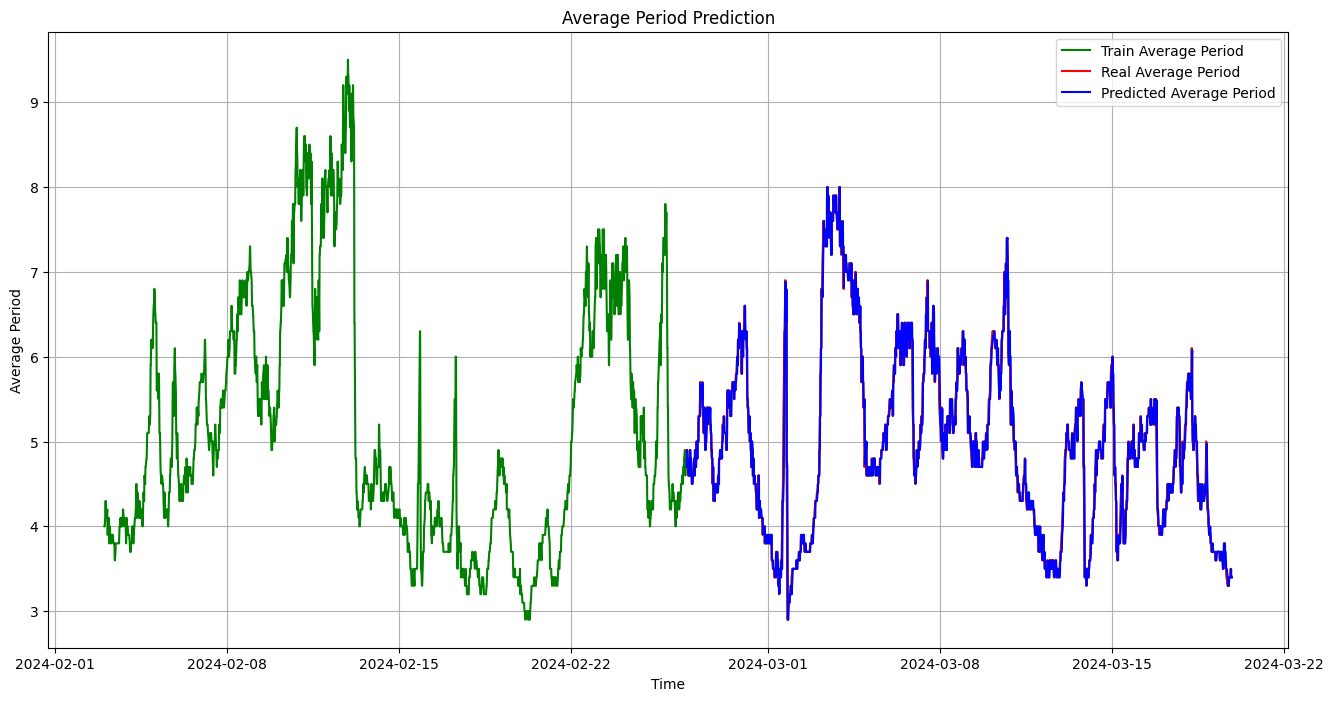

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(ny_buoy_df["date"], ny_buoy_df['average_period'], color='green', label = 'Train Average Period')
plt.plot(test_data["date"], y, color = 'red', label = 'Real Average Period')
plt.plot(test_data["date"], predictions, color = 'blue', label = 'Predicted Average Period')
plt.title('Average Period Prediction')
plt.xlabel('Time')
plt.ylabel('Average Period')
plt.legend()
plt.grid(True)
plt.savefig('arima_model.pdf')
plt.show()